# Pendulum with Vibrating Base

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [1]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib.  
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

In [2]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# pydrake imports
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, Parser,
                         PlanarSceneGraphVisualizer, Simulator, VectorSystem,
                         Multiplexer, MatrixGain, LogOutput, ConstantVectorSource, 
                         Saturation, WrapToSystem, LinearQuadraticRegulator, SceneGraph, 
                        MultibodyPlant, SignalLogger)

from pydrake.systems.drawing import plot_system_graphviz
from pydrake.examples.acrobot import AcrobotSpongController
from pydrake.systems.analysis import Simulator

# underactuated imports
from underactuated import FindResource, ManipulatorDynamics



## Problem Description
In this problem you will write the controller to make the pendulum with vibrating base spin at constant velocity.
At the end of the notebook, you will be able to check your work in a simulation environment we set up for you.

**These are the main steps of the exercise:**
1. Construct the physical model of the vibrating pendulum. This is done automatically by "parsing" a `.urdf` (Unified Robot Description Format) file.
2. Implement the controller you derived in the written part of this exercise. _This is the only piece of code you will need to write._
3. Wire up the closed-loop block diagram: connect the controller output with the system input, the system output with the visualizer etc.
4. Set up and run a simulation.

## Parse the `.urdf`
The first block of our diagram is the vibrating pendulum.
No need to write its equations of motion by hand: all the parameters of the system are described in its `.urdf` file.
Drake can directly parse this file, and construct a `MultibodyPlant` (i.e. the vibrating-pendulum block in our diagram).
The `.urdf` file contains all the physical data of the system, the visualization parameters (shapes and colors of the bodies), etc.
Its html-like syntax is very easy to understand, give it a try!

Our robot has two bodies:
1. The base. This moves on a 1D rail and oscillates according to the harmonic law $h \sin (\omega t)$.
2. The pendulum. It is connected to the base through a pin. This is the body you will need to control.

**Attention!** Since the robot has two bodies, it also has two configuration variables.
When writing the controller, we will take care of the first (position of the base) and ensure that it oscillates as required.
Then the problem will be reduced to the control of the pendulum only.

[-2.35]
[2.35]


<IPython.core.display.Javascript object>


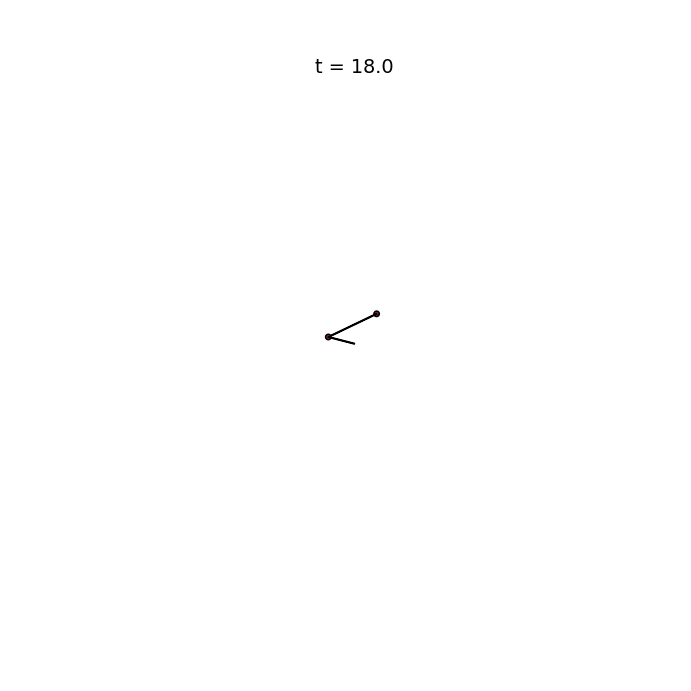

[0. 0. 0. 0.]


<IPython.core.display.Javascript object>


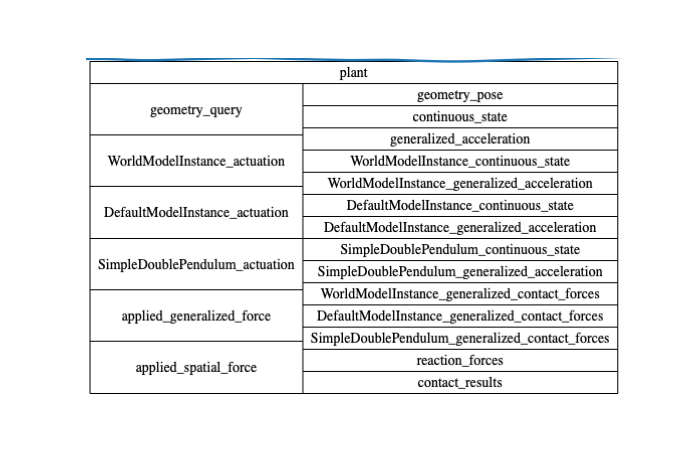

[ 0.00000000e+00  3.12842462e-08  1.12623330e-06 ... -2.27627664e+01
 -2.27183050e+01 -2.26905012e+01]


In [3]:
import os
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

# think of the builder as the construction site of our block diagram
builder = DiagramBuilder()

# instantiate the vibrating pendulum and the scene graph
# the scene graph is a container for the geometries of all the physical systems in our diagram


# double_pendulum = MultibodyPlant(time_step=0.01)
# scene_graph = SceneGraph()
# double_pendulum.RegisterAsSourceForSceneGraph(scene_graph)
# Parser(double_pendulum).AddModelFromFile('double_pendulum_no_shoulder.urdf')
# double_pendulum.Finalize()

#print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(2)).position_lower_limits()) #applied a limit
#print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(2)).position_upper_limits()) #applied a limit


double_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
    builder,
    time_step=0 # discrete update period , set to zero since system is continuous
)

#Parser(double_pendulum, scene_graph).AddModelFromFile('double_pendulum_no_shoulder.urdf')
#double_pendulum.Finalize()


#parse the urdf and populate the vibrating pendulum
urdf_path = 'double_pendulum_no_shoulder.urdf'
Parser(double_pendulum).AddModelFromFile(urdf_path)
double_pendulum.Finalize()

print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(2)).position_lower_limits())
print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(2)).position_upper_limits())


# Set the constant torque (you can change the value here if you like)
torque_system = builder.AddSystem(ConstantVectorSource([[0.]]))
# plot_system_graphviz(double_pendulum)
builder.Connect(torque_system.get_output_port(0), double_pendulum.get_input_port(3))
visualizer = builder.AddSystem(
   PlanarSceneGraphVisualizer(scene_graph, xlim=[-10., 10.], ylim=[-10., 10.], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
               visualizer.get_input_port(0))

logger = builder.AddSystem(SignalLogger(4))
builder.Connect(double_pendulum.get_state_output_port(), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
print(context.get_state().get_continuous_state().CopyToVector())

plant_context = diagram.GetMutableSubsystemContext(double_pendulum, context)
double_pendulum.SetPositionsAndVelocities(plant_context, [3*np.pi/4, 0, 0, 0])
# Simulate
duration = 18.0 if get_ipython() else 0.1 # sets a shorter duration during testing
context.SetTime(0.0)
# AdvanceToAndVisualize(simulator, visualizer, duration)



fig, ax = plt.subplots()
context.SetTime(0.)
context.SetContinuousState([3*np.pi/4, 0, 0, 0]) #np.random.randn(4,1))
#simulator.AdvanceTo(duration)
AdvanceToAndVisualize(simulator, visualizer, duration)
print(logger.data()[1])
plt.plot(logger.data()[1])
plt.show()

<IPython.core.display.Javascript object>


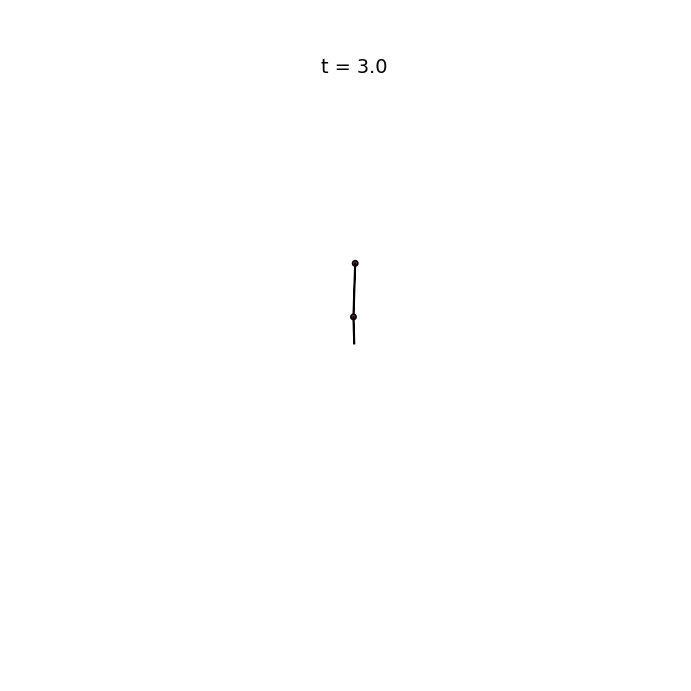

In [4]:
from pydrake.systems.framework import BasicVector


def BalancingLQR(plant):
  
    context = plant.CreateDefaultContext()

    #context.FixInputPort(3, BasicVector([0, 0])) #overrides previous values stored at port if connection already exists
    plant.get_actuation_input_port().FixValue(context, [0])
    context.get_mutable_continuous_state_vector().SetFromVector([np.pi, 0, 0, 0]) # be sure this is an equilibrium point
    
#     upright_state = np.array([np.pi, 0, 0, 0])
#     context.SetContinuousState(upright_state)

#     context.get_mutable_continuous_state_vector()\
#         .SetFromVector(BasicVector(upright_state).CopyToVector())

    Q = np.diag((10., 10., 1., 1.))
    R = [1]
    #R = np.diag((1., 1.))
    
    return LinearQuadraticRegulator(double_pendulum, context, Q, R, input_port_index=3)
    

# think of the builder as the construction site of our block diagram
builder = DiagramBuilder()

# instantiate the vibrating pendulum and the scene graph
# the scene graph is a container for the geometries of all the physical systems in our diagram
double_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
    builder,
    time_step=0. # discrete update period , set to zero since system is continuous
)

# parse the urdf and populate the vibrating pendulum
urdf_path = 'double_pendulum_no_shoulder.urdf'
Parser(double_pendulum).AddModelFromFile(urdf_path)
double_pendulum.Finalize()

# double_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
#     builder,
#     time_step=0.001 # discrete update period , set to zero since system is continuous
# )

# # double_pendulum = MultibodyPlant(time_step=0.001)
# Parser(double_pendulum, scene_graph).AddModelFromFile('double_pendulum_no_shoulder.urdf')
# double_pendulum.Finalize()

plot_system_graphviz(double_pendulum)
saturation = builder.AddSystem(Saturation(min_value=[-100], max_value=[100]))
builder.Connect(saturation.get_output_port(0), double_pendulum.get_actuation_input_port())
wrapangles = WrapToSystem(4)
wrapangles.set_interval(0, 0, 2. * np.pi)
wrapangles.set_interval(1, -np.pi, np.pi)
wrapto = builder.AddSystem(wrapangles)
builder.Connect(double_pendulum.get_state_output_port(), wrapto.get_input_port(0))
plot_system_graphviz(double_pendulum)
controller = builder.AddSystem(BalancingLQR(double_pendulum))
builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))



# Setup visualization
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-10., 10.], ylim=[-10., 10.], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))
diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()


# Simulate
duration = 3.0 if get_ipython() else 0.1 # sets a shorter duration during testing
for i in range(1):
    context.SetTime(0.0)
    context.SetContinuousState([np.pi, 0, 0, 0] + 0.05*np.random.randn(4,))
    simulator.Initialize()
    AdvanceToAndVisualize(simulator, visualizer, duration)


In [5]:
# Spong Controller

#get mass matrix
#get ke, kp, kd 
#determine potential + kinetic energy
#E desired = potential energy of first joint + potential energy of second joint

class SpongController(VectorSystem):
    
    def __init__(self, double_pendulum):
        
        # 4 inputs: double pendulum state
        # 1 output: elbow torque
        VectorSystem.__init__(self, 4,  1)
        
        # the controller keeps track of the last value of
        # the elbow torque and the last state of the double pendulum
        self.last_delta = 0
        self.last_state = np.full(4, np.nan)
        
        self.double_pendulum = double_pendulum
        self.double_pendulum_context = double_pendulum.CreateDefaultContext()


        self.k_e = 5
        self.k_p = 50
        self.k_d = 20
        self.length = 1
        self.m1 = 2.4367
        self.m2 = 0.6178
        self.l1 = 0.2563 #length
        self.lc1 = 1.6738 #length to center aka length/2
        self.lc2 = 1.5651
        self.Ic1 = -4.7443 #inertia
        self.Ic2 = -1.0068 
        self.b1 = 0.0320
        self.b2 = 0.0413 
        
    
    # note that this function is called at each time step
    def DoCalcVectorOutput(self, context, state, unused, delta):
        
#         print("Before ", state)
        
#         if state[1] > 3*np.pi/4:
#             state[1] = 3*np.pi/4
#         elif state[1] < -3*np.pi/4:
#             state[1] = -3*np.pi/4
        
#         print("After ", state)
            
        self.double_pendulum_context.SetContinuousState(state)

        M = self.double_pendulum.CalcMassMatrixViaInverseDynamics(self.double_pendulum_context)
        #print("Mass Matrix", M)
        PE = double_pendulum.EvalPotentialEnergy(self.double_pendulum_context)
        #print("PE", PE)
        KE = double_pendulum.EvalKineticEnergy(self.double_pendulum_context)
        #print('KE', KE)
        E = PE + KE
        E_desired = (self.m1*self.lc1 + self.m2*self.lc2)*9.81  
        
        E_tilde = E - E_desired
        u_e = -self.k_e*E_tilde*state[2]
        
        #print(M)
        M = M.astype(float)
        #print(np.linalg.inv(M))
        M_inverse = np.linalg.inv(M)
        y = -self.k_p*state[1] - self.k_d*state[3]
        a3 = M_inverse[1, 1]
        a2 = M_inverse[0, 1]
        a1 = M_inverse[0, 0]
        
        #bias calculation
        
#         s1 = np.sin(state[0])
#         s2 = np.sin(state[1])
#         s12 = np.sin(state[0] + state[1])
        
        
#         m2l1lc2 = self.m2 * self.l1 * self.lc2
#         bias0 = -2*m2l1lc2*s2*state[3]*state[2] - m2l1lc2*s2*state[3]*state[3]
#         bias1 = m2l1lc2 * s2 * state[2]*state[2]
        
#         bias0 += 9.81*self.m1*self.lc1*s1 + 9.81*self.m2*(self.l1*s1 + self.lc2*s12) 
#         bias1 += 9.81*self.m1*self.lc2*s12
        
#         bias0 += self.b1*state[2]
#         bias1 += self.b2*state[3]
        

        
        Cv = self.double_pendulum.CalcBiasTerm(self.double_pendulum_context)
        tauG = self.double_pendulum.CalcGravityGeneralizedForces(self.double_pendulum_context)
        #print()
#         bias0 = Cv[0] + tauG[0]
#         bias1 = Cv[1] + tauG[1]
        
        tau1 = -Cv[0] + tauG[0]
        tau2 = -Cv[1] + tauG[1]
        
        
        #u_p = (a2 * bias0 + y) / a3 + bias1
        
        
        q2d = y + u_e
        u = (M[1, 1]-M[1, 0]*(a1)*(M[0, 1]))*q2d - tau2 + M[1, 0]*(a1)*tau1
        
        
        
        
        # assign value of the preload at each time step
        delta[:] = [u] # modify here
        
        # update controller internal memory
        self.last_delta = delta[0]
        self.last_state = state
        
        
    # feel free to add methods to this class if you need to
    # modify here

In [6]:
#get mass matrix
#get ke, kp, kd 
#determine potential + kinetic energy
#E desired = potential energy of first joint + potential energy of second joint
Vs = []
Es = []
us = []
class BanavarController(VectorSystem):
    
    def __init__(self, double_pendulum):
        
        # 4 inputs: double pendulum state
        # 1 output: elbow torque
        VectorSystem.__init__(self, 4,  1)
        
        # the controller keeps track of the last value of
        # the elbow torque and the last state of the double pendulum
        self.last_delta = 0
        self.last_state = np.full(4, np.nan)
        
        self.double_pendulum = double_pendulum
        self.double_pendulum_context = double_pendulum.CreateDefaultContext()
        
        self.k_e = 1
        self.k_p = 100000
        self.k_d = 100000
        #self.length = 1
        self.m1 = 34.9 #2.4367
        self.m2 = 18.5 #0.6178
        self.lc1 = 1.08 #1.6738 #length to center aka length/2
        self.lc2 = 0.395 #1.5651
        self.l1 = self.lc1*2 #length
#         self.Ic1 = -4.7443 #inertia
#         self.Ic2 = -1.0068 
#         self.b1 = 0.0320
#         self.b2 = 0.0413 


    def DoCalcVectorOutput(self, context, state, unused, delta):
            
        self.double_pendulum_context.SetContinuousState(state)

        M = self.double_pendulum.CalcMassMatrixViaInverseDynamics(self.double_pendulum_context)
        #print("Mass Matrix", M)
        PE = double_pendulum.EvalPotentialEnergy(self.double_pendulum_context)
        #print("State: ", state)
        #print("PE: ", PE)
        KE = double_pendulum.EvalKineticEnergy(self.double_pendulum_context)
        #print('KE', KE)
        E = PE + KE
        
        E_desired = 709.135
        E_desired = (self.m1*self.lc1 + self.m2*(self.lc2 + self.l1))*9.81  
        #print("E", E)
        #print("E_desired", E_desired)
        E_tilde = E - E_desired
        
        
        ### Lyapunov ###
        V = 0.5*(self.k_p*state[1]**2 + self.k_d*state[3]**2 + self.k_e*E_tilde**2)
        Vs.append(V)
        Es.append(E)
        
        #print(M)
        M = M.astype(float)
        #print(np.linalg.inv(M))
        M_inverse = np.linalg.inv(M)
        
        Cv = self.double_pendulum.CalcBiasTerm(self.double_pendulum_context)
        #print("Cv")
        #print(Cv)
        tauG = self.double_pendulum.CalcGravityGeneralizedForces(self.double_pendulum_context)
        #print("tauG")
        #print(tauG)
        
        f4 = M_inverse.dot(-Cv + tauG)[1]
        #print("f4")
        #print(f4)
        B = np.array([[0], [1]])
        g4 = (M_inverse.dot(B))[1]
        #print("g4", g4)
        u = -(state[3] + self.k_p*state[1] + self.k_d*f4) / (self.k_d*g4 + self.k_e*E_tilde)
        us.append(u)
        # assign value of the preload at each time step
        delta[:] = [u] # modify here
        #print(state[0])
        # update controller internal memory
        self.last_delta = delta[0]
        self.last_state = state

<IPython.core.display.Javascript object>


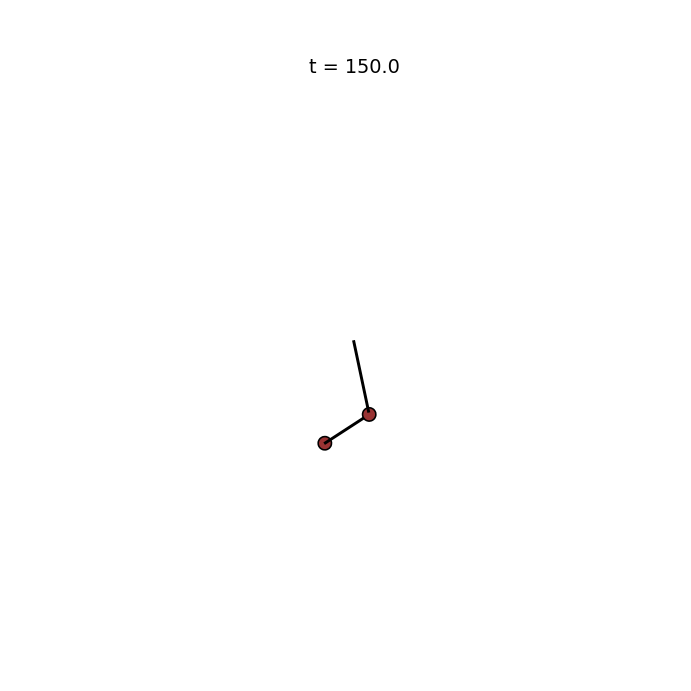

<IPython.core.display.Javascript object>


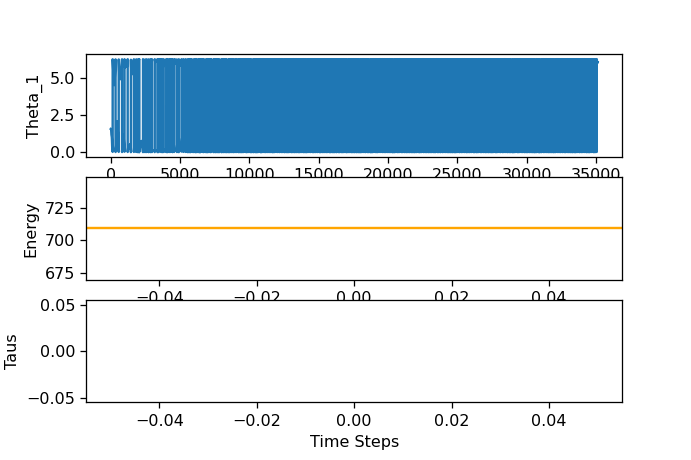

In [7]:
   # think of the builder as the construction site of our block diagram
builder = DiagramBuilder()

# instantiate the vibrating pendulum and the scene graph
# the scene graph is a container for the geometries of all the physical systems in our diagram
double_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
    builder,
    time_step=0. # discrete update period , set to zero since system is continuous
)

# parse the urdf and populate the vibrating pendulum
urdf_path = 'double_pendulum_no_shoulder-banavar.urdf'
#urdf_path = 'double_pendulum_no_shoulder.urdf'
Parser(double_pendulum).AddModelFromFile(urdf_path)
double_pendulum.Finalize()
# print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(0)).position_lower_limits())
# print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(0)).position_lower_limits())
# print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(0)).position_upper_limits())
# print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(0)).position_upper_limits())



saturation = builder.AddSystem(Saturation(min_value=[-100], max_value=[100]))
builder.Connect(saturation.get_output_port(0), double_pendulum.get_actuation_input_port())
wrapangles = WrapToSystem(4)
wrapangles.set_interval(0, 0, 2. * np.pi)
wrapangles.set_interval(1, -np.pi, np.pi)
wrapto = builder.AddSystem(wrapangles)
builder.Connect(double_pendulum.get_state_output_port(), wrapto.get_input_port(0))
#plot_system_graphviz(double_pendulum)
controller = builder.AddSystem(SpongController(double_pendulum))
builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))



# Setup visualization
visualizer = builder.AddSystem(
   PlanarSceneGraphVisualizer(scene_graph, xlim=[-4., 4.], ylim=[-4., 4.], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
               visualizer.get_input_port(0))

logger = builder.AddSystem(SignalLogger(4))
builder.Connect(wrapto.get_output_port(0), logger.get_input_port(0))
diagram = builder.Build()
#plot_system_graphviz(diagram)


# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
#plant_context = diagram.GetMutableSubsystemContext(double_pendulum, context)
#double_pendulum.SetPositionsAndVelocities(plant_context, [np.pi, 0, 0, 0])

# Simulate
duration = 150.0 if get_ipython() else 0.1 # sets a shorter duration during testing



fig, ax = plt.subplots(3)
context.SetTime(0.)
context.SetContinuousState([np.pi/2, 0, 0, 0]) #np.random.randn(4,1))
simulator.AdvanceTo(duration)
#AdvanceToAndVisualize(simulator, visualizer, duration)
ax[0].plot(logger.data()[0])
ax[0].set_xlabel("Time Steps")
ax[0].set_ylabel("Theta_1")
ax[1].plot(Es)
ax[1].axhline(709.135, color='orange')
ax[1].set_xlabel("Time Steps")
ax[1].set_ylabel("Energy")
ax[2].plot(us)
ax[2].set_xlabel("Time Steps")
ax[2].set_ylabel("Taus")

plt.show()



# for i in range(1):
#     context.SetTime(0.0)
#     #context.SetContinuousState([3*np.pi/4, 0, 0, 0] + 0.05*np.random.randn(4,))
#     simulator.Initialize()
#     AdvanceToAndVisualize(simulator, visualizer, duration)
